In [98]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import seaborn as sns
import matplotlib.dates as mdates

### Optimized

In [109]:
# Import solved network
nw = pypsa.Network("/Users/nomio/Documents/REU/Fall_2324/test/pypsa-usa/workflow/results/western/networks/elec_s_30_ec_lv1.25_Co2L1.25.nc")
ba_carrier = nw.generators_t["p"].drop(['Arizona0 0 CCGT', 'Arizona0 0 OCGT', 'Arizona0 0 coal', 'Arizona0 0 hydro', 'Arizona0 0 nuclear', 
                           'Arizona0 0 oil', 'Arizona0 0 onwind','Arizona0 0 solar'], axis=1)
optimized = ba_carrier.groupby(axis="columns", by=nw.generators["carrier"]).sum().loc["2019-01-02 00:00:00":"2019-12-30 23:00:00"]
optimized['CCGT'] = optimized['CCGT'] + optimized['OCGT']
optimized_final = optimized.drop(['OCGT','offwind','load'], axis=1)
op_f = optimized_final.rename(columns={'CCGT':'Natural gas', 'hydro':'Hydro', 'oil':'Oil', 'onwind':'Onshore wind', 'solar':'Solar', 'nuclear':'Nuclear','coal':'Coal', 'geothermal':'Other'})
optimized = op_f /1e3

INFO:pypsa.io:Imported network elec_s_30_ec_lv1.25_Co2L1.25.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [101]:
from collections import OrderedDict
buses = []
for i in range(nw.generators.bus.size):
    if nw.generators.bus[i] not in buses:
        buses.append(nw.generators.bus[i])
buses_clean = [ba.split('0')[0] for ba in buses]
buses_clean = [ba.split('-')[0] for ba in buses_clean]
buses = list(OrderedDict.fromkeys(buses_clean))
buses.pop(1)
buses

['AVA',
 'BANC',
 'BPAT',
 'CHPD',
 'CISO',
 'DOPD',
 'EPE',
 'GCPD',
 'GRID',
 'IID',
 'IPCO',
 'LDWP',
 'NEVP',
 'NWMT',
 'PACE',
 'PACW',
 'PGE',
 'PNM',
 'PSCO',
 'PSEI',
 'TEPC',
 'TIDC',
 'WACM',
 'WALC',
 'WAUW']

## Historic

In [102]:
selected_cols = ["Balancing Authority", 
                 "UTC Time at End of Hour",  
            "Net Generation (MW) from Natural Gas (Adjusted)",
            "Net Generation (MW) from Coal (Adjusted)",
            "Net Generation (MW) from Nuclear (Adjusted)",
            "Net Generation (MW) from All Petroleum Products (Adjusted)",
            "Net Generation (MW) from Hydropower and Pumped Storage (Adjusted)",
            "Net Generation (MW) from Solar (Adjusted)",
            "Net Generation (MW) from Wind (Adjusted)",
            "Net Generation (MW) from Other Fuel Sources (Adjusted)"]
historic_first = pd.read_csv(
    "/Users/nomio/Documents/REU/Fall_2324/pypsa-usa-n/workflow/resources/eia/6moFiles/EIA930_BALANCE_2019_Jan_Jun.csv",
    index_col = [0,1],
    header = 0,
    parse_dates=True,
    date_format="%m/%d/%Y %I:%M:%S %p",
    usecols = selected_cols
)
historic_first_df = historic_first.loc[buses].fillna(0).replace({',': ''}, regex=True).astype(float)
historic_second = pd.read_csv(
    "/Users/nomio/Documents/REU/Fall_2324/pypsa-usa-n/workflow/resources/eia/6moFiles/EIA930_BALANCE_2019_Jul_Dec.csv",
    index_col = [0,1],
    header = 0,
    parse_dates=True,
    date_format="%m/%d/%Y %I:%M:%S %p",
    usecols = selected_cols
)
historic_second_df = historic_second.loc[buses].fillna(0).replace({',': ''}, regex=True).astype(float)
historic = pd.concat([historic_first_df, historic_second_df], axis=0).groupby(['UTC Time at End of Hour']).sum()
historic[historic < 0] = 0
col_names = {'Net Generation (MW) from Natural Gas (Adjusted)':'Natural gas', 
                                                  'Net Generation (MW) from Hydropower and Pumped Storage (Adjusted)':'Hydro', 
                                                  'Net Generation (MW) from All Petroleum Products (Adjusted)':'Oil', 
                                                  'Net Generation (MW) from Wind (Adjusted)':'Onshore wind', 
                                                  'Net Generation (MW) from Solar (Adjusted)':'Solar', 
                                                  'Net Generation (MW) from Nuclear (Adjusted)':'Nuclear',
                                                  'Net Generation (MW) from Coal (Adjusted)':'Coal', 
                                                  'Net Generation (MW) from Other Fuel Sources (Adjusted)':'Other'}
historic = historic.rename(columns=col_names)
rearrange = ['Natural gas', 'Coal', 'Other', 'Hydro', 'Nuclear', 'Oil', 'Onshore wind', 'Solar']
historic = historic[rearrange].loc["2019-01-02 00:00:00":"2019-12-30 23:00:00"] / 1e3

/var/folders/5m/65dpkd513dd24d_lyyxsb5hr0000gn/T/ipykernel_47254/3749116703.py:11: DtypeWarning: Columns (33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  historic_first = pd.read_csv(
/var/folders/5m/65dpkd513dd24d_lyyxsb5hr0000gn/T/ipykernel_47254/3749116703.py:20: DtypeWarning: Columns (33,34,35,36,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  historic_second = pd.read_csv(


,Natural gas,Coal,Other,Hydro,Nuclear,Oil,Onshore wind,Solar
UTC Time at End of Hour,,,,,,,,
2019-01-02 00:00:00,18.691,14.482,1.785,16.226,3.441,0.089,2.294,2.849
2019-01-02 01:00:00,22.957,15.673,1.767,19.678,3.444,0.088,2.519,0.053
2019-01-02 02:00:00,24.050,16.096,1.833,22.409,3.443,0.091,2.518,0.000
2019-01-02 03:00:00,23.953,16.146,1.851,22.355,3.439,0.089,2.558,0.000
2019-01-02 04:00:00,23.578,16.183,1.877,21.859,3.437,0.092,2.776,0.000
...,...,...,...,...,...,...,...,...
2019-12-30 19:00:00,20.790,14.441,1.673,14.767,3.441,0.107,4.366,7.671
2019-12-30 20:00:00,20.138,14.228,1.665,14.096,3.441,0.139,4.431,8.530
2019-12-30 21:00:00,20.081,14.069,1.735,13.661,3.438,0.150,4.282,8.158


In [72]:
historic - optimized
historic[historic.index.duplicated(keep=False)]
historic.loc["2019-07-01 00:00:00":"2019-07-01 10:00:00"]

,Natural gas,Coal,Other,Hydro,Nuclear,Oil,Onshore wind,Solar
UTC Time at End of Hour,,,,,,,,
2019-07-01 00:00:00,22.504,15.320,1.506,23.550,3.416,0.149,5.094,11.858
2019-07-01 01:00:00,23.220,15.400,1.494,24.452,3.416,0.149,6.563,9.613
2019-07-01 02:00:00,25.399,15.484,1.557,25.719,3.418,0.149,6.753,4.503
2019-07-01 03:00:00,26.870,15.757,1.504,26.344,3.418,0.149,6.250,0.475
2019-07-01 04:00:00,25.679,15.480,1.562,25.949,3.416,0.149,7.099,0.010
2019-07-01 05:00:00,24.126,15.129,1.540,24.449,3.418,0.150,6.962,0.000
2019-07-01 06:00:00,21.291,14.654,1.606,21.054,3.419,0.151,6.554,0.000
2019-07-01 07:00:00,15.700,5.247,1.607,16.887,3.420,0.090,5.460,0.000
2019-07-01 07:00:00,2.181,7.384,0.078,0.881,0.000,0.060,0.932,0.001


## Plot

/Users/nomio/miniconda3/envs/pypsa-usa/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:1598: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(None, 0)


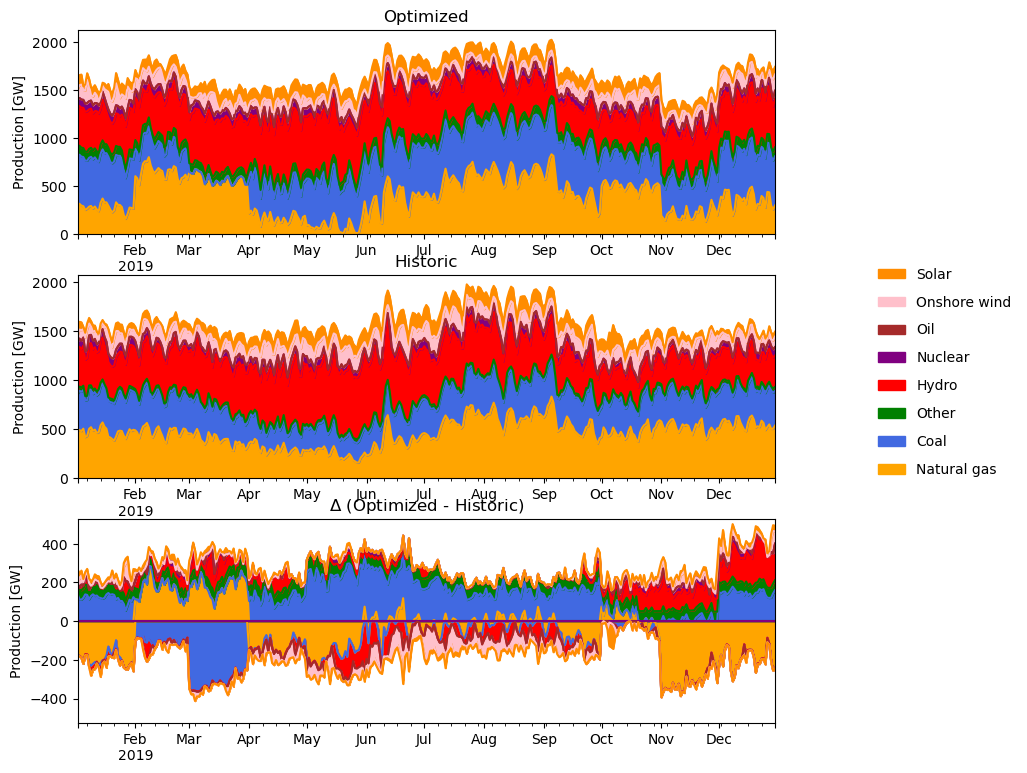

In [127]:
fig, axes = plt.subplots(3, 1, figsize=(9, 9))
colors=['orange','royalblue','green','red','purple','brown','pink','darkorange'] 
kwargs = dict(color=colors, legend=False, ylabel="Production [GW]", xlabel="")
optimized.resample('1D').sum().plot.area(ax=axes[0], **kwargs, title="Optimized")
historic.resample('1D').sum().plot.area(ax=axes[1], **kwargs, title="Historic")

diff = (optimized - historic).fillna(0).resample('1D').sum()
diff.clip(lower=0).plot.area(
    ax=axes[2], **kwargs, title="$\Delta$ (Optimized - Historic)"
)
lim = axes[2].get_ylim()[1]
diff.clip(upper=0).plot.area(ax=axes[2], **kwargs)
axes[2].set_ylim(bottom=-lim, top=lim)

h, l = axes[0].get_legend_handles_labels()
fig.legend(
    h[::-1],
    l[::-1],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    frameon=False,
    labelspacing=1,
)

In [90]:
data = pd.concat([historic, optimized], keys=["Historic", "Optimized"], axis=1)
data.columns.names = ["Kind", "Carrier"]
data

Kind                   Historic                                         
Carrier             Natural gas    Coal  Other   Hydro Nuclear    Oil   
2019-01-02 00:00:00      18.691  14.482  1.785  16.226   3.441  0.089  \
2019-01-02 01:00:00      22.957  15.673  1.767  19.678   3.444  0.088   
2019-01-02 02:00:00      24.050  16.096  1.833  22.409   3.443  0.091   
2019-01-02 03:00:00      23.953  16.146  1.851  22.355   3.439  0.089   
2019-01-02 04:00:00      23.578  16.183  1.877  21.859   3.437  0.092   
...                         ...     ...    ...     ...     ...    ...   
2019-12-30 19:00:00      20.790  14.441  1.673  14.767   3.441  0.107   
2019-12-30 20:00:00      20.138  14.228  1.665  14.096   3.441  0.139   
2019-12-30 21:00:00      20.081  14.069  1.735  13.661   3.438  0.150   
2019-12-30 22:00:00      20.774  14.202  1.729  13.601   3.440  0.150   
2019-12-30 23:00:00      21.162  14.517  1.738  13.790   3.437  0.150   

Kind                                      Optimized                        
Carrier             Onshore wind  Solar Natural gas       Coal     Other   
2019-01-02 00:00:00        2.294  2.849    9.364098  21.381435  3.914182  \
2019-01-02 01:00:00        2.519  0.053   12.679453  21.381438  3.914182   
2019-01-02 02:00:00        2.518  0.000   16.395996  21.381455  3.914182   
2019-01-02 03:00:00        2.558  0.000   18.576152  21.381460  3.914182   
2019-01-02 04:00:00        2.776  0.000   18.893083  21.381460  3.914182   
...                          ...    ...         ...        ...       ...   
2019-12-30 19:00:00        4.366  7.671   11.346526  21.381533  3.914186   
2019-12-30 20:00:00        4.431  8.530    8.161454  21.381529  3.914185   
2019-12-30 21:00:00        4.282  8.158    6.518076  21.381526  3.914185   
2019-12-30 22:00:00        3.925  7.606    5.216439  21.381527  3.914185   
2019-12-30 23:00:00        3.476  6.444    6.944681  21.381526  3.914185   

Kind                                                                        
Carrier                  Hydro   Nuclear       Oil Onshore wind      Solar  
2019-01-02 00:00:00  17.781978  3.522992  0.000014     2.965874   6.930560  
2019-01-02 01:00:00  17.978800  3.522993  0.000014     3.288149   1.868615  
2019-01-02 02:00:00  16.793894  3.522993  0.000014     3.619706   0.000000  
2019-01-02 03:00:00  15.644175  3.522993  0.000014     3.895768   0.000000  
2019-01-02 04:00:00  14.779781  3.522993  0.000014     4.203139   0.000000  
...                        ...       ...       ...          ...        ...  
2019-12-30 19:00:00  18.534974  3.522995  0.000016     5.663904  11.865304  
2019-12-30 20:00:00  19.174946  3.522994  0.000016     5.424449  12.902157  
2019-12-30 21:00:00  20.753107  3.522994  0.000016     5.082252  12.950819  
2019-12-30 22:00:00  22.535896  3.522994  0.000016     4.859077  11.422359  
2019-12-30 23:00:00  22.605607  3.522994  0.000016     4.502675   8.543818  

[8712 rows x 16 columns]

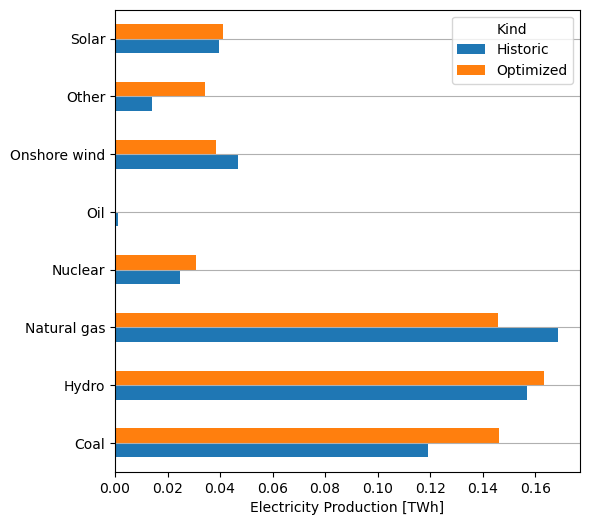

In [91]:
fig, ax = plt.subplots(figsize=(6, 6))

df = data.groupby(level=["Kind", "Carrier"], axis=1).sum().sum().unstack().T
df = df / 1e6  # TWh
df.plot.barh(ax=ax, xlabel="Electricity Production [TWh]", ylabel="")
ax.grid(axis="y")

In [97]:
difference = historic - optimized

0